# Dog vs Cat

## Extracción de características 2

Importamos algunas librerías que vamos a utilizar

In [1]:
import numpy as np
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 

Instalamos tensorflow si no lo tenemos instalado anteriormente

In [ ]:
!pip install tensorflow

Inicializamos variables

En este caso utilizaremos el dataset `cat_dog_100` pero en cualquier momento se puede cambiar

In [70]:
rutaDogsTrain = 'cat_dog_100/train/dog'
rutaDogsTest = 'cat_dog_100/test/dog'
rutaCatsTrain = 'cat_dog_100/train/cat'
rutaCatsTest = 'cat_dog_100/test/cat'

tamanoMax = 128 
sizeVentana = 32
tamanoMax = int(tamanoMax/sizeVentana)*sizeVentana

Se recorren los directorios para obtener los nombres de las imágenes

In [71]:
from os import walk

dogTrain = []
dogTest = []
catTest = []
catTrain = []
for (dirpath, dirnames, filenames) in walk(rutaDogsTrain):
    dogTrain.extend(filenames)
    
for (dirpath, dirnames, filenames) in walk(rutaDogsTest):
    dogTest.extend(filenames)

for (dirpath, dirnames, filenames) in walk(rutaCatsTest):
    catTest.extend(filenames)

for (dirpath, dirnames, filenames) in walk(rutaCatsTrain):
    catTrain.extend(filenames)
    
print(f'{rutaDogsTrain}/{dogTrain[0]}')

cat_dog_100/train/dog/dog.10000.jpg


La función `resize_image` redimensiona la imagen en *tamanoMax x tamanoMax*.

Probaremos a recortar la imagen para no deformarlas y así comprobar si obtenemos un mejor resultado.

In [72]:
def recorta_imagen(imagen, n):
    """
    Esta función recibe una imagen y un tamaño n y recorta la imagen de tal manera que el número final de filas/columnas 
    sea múltiplo de n. La funció debe recortar las filas de la derecha/abajo.
    """
    size = np.min([int(imagen.shape[0]/n)*n, int(imagen.shape[1]/n)*n])
    return imagen[:size, :size]

def resize_image(imagen, sizeVentana, tamanoMax, recorta=False):
    if(recorta): imagen = recorta_imagen(imagen, sizeVentana)
    imagen2 = cv2.resize(imagen, [tamanoMax,tamanoMax])
    return imagen2

Función para aplicar un filtro

In [73]:
def filtro(imagen, mascara):
    a = mascara.shape[0]//2
    b = mascara.shape[1]//2
    imagen_ampliada = cv2.copyMakeBorder(imagen, a, a, b, b, cv2.BORDER_REPLICATE)
    imagen2 = np.zeros(imagen.shape)
    for i in range(a, imagen.shape[0] + a):
        for j in range(b, imagen.shape[1] + b):
            imagen2[i-a, j-b] = np.sum(imagen_ampliada[i-a:i+a+1, j-b:j+b+1] * mascara)
            
    return imagen2

Función para aplicar un filtro espacial de aproximación de la derivada parcial y obtenemos Phi y E

In [74]:
def gradiente(imagen):
    m_g_x = np.array([[0, -1, 0], [0, 0, 0], [0, 1, 0]])
    m_g_y = np.array([[0, 0, 0], [-1, 0, 1], [0, 0, 0]])
    Ix = filtro(imagen, m_g_x)
    Iy = filtro(imagen, m_g_y)
    E = np.sqrt(Ix**2 + Iy**2)
    Phi = np.rad2deg(np.arctan2(Iy, Ix))
    
    return E, Phi

La función `transforma_imagen` divide en celdas de tamaños sizeVentana y contruimos un histograma para cada celda en función de Phi y E 

In [75]:
def transforma_bloque(celdaPhi, celdaE, bins = 9):
    celdaPhi = np.abs(celdaPhi)
    hp = cv2.calcHist([np.uint8(celdaPhi)], [0], None, [bins], [0, 180])
    a = 180/bins 
    for i in range(bins):
        hp[i] += np.sum(celdaE[(celdaPhi > a*i) & (celdaPhi < -a*(i+1))])
    hp = hp / np.sqrt(np.sum(hp**2)) #Normalizar
    return np.ravel(hp)

In [76]:
def transforma_imagen(imagen, sizeVentana, tamanoMax):
    E, Phi = gradiente(imagen)
    Phi = resize_image(Phi, sizeVentana, tamanoMax, True)  #Mejor recortar a True
    E = resize_image(E, sizeVentana, tamanoMax, True) #Mejor recortar a True
    caracteristicas = []
    a = int(Phi.shape[0]/sizeVentana)
    for i in range(a):
        for j in range(a):
            celdaPhi = Phi[i*sizeVentana:(i+1)*sizeVentana,j*sizeVentana:(j+1)*sizeVentana]
            celdaE = E[i*sizeVentana:(i+1)*sizeVentana,j*sizeVentana:(j+1)*sizeVentana]
            h = transforma_bloque(celdaPhi, celdaE)  
            caracteristicas.append(h)
    return np.concatenate(caracteristicas)

Extraemos las características de nuestro conjunto de imágenes (Train y Test)

In [77]:
X = []
m = 2
for i in tqdm(range(len(dogTrain)), desc = "Perros", colour = '#FF88F8'):
    imagen = cv2.imread(f'{rutaDogsTrain}/{dogTrain[i]}',0)
    caracteristicas = transforma_imagen(imagen, sizeVentana, tamanoMax)
    X.append(caracteristicas)

for i in tqdm(range(len(catTrain)), desc = "Gatos", colour = '#88FFDD'):
    imagen = cv2.imread(f'{rutaCatsTrain}/{catTrain[i]}',0)
    caracteristicas = transforma_imagen(imagen, sizeVentana, tamanoMax)
    X.append(caracteristicas)
    
X = np.array(X)
y = np.hstack((np.ones(len(dogTrain)), np.zeros(len(catTrain)))).reshape(-1, 1)


Gatos: 100%|██████████| 100/100 [03:47<00:00,  2.28s/it]


In [78]:
Xtest = []
for i in tqdm(range(len(dogTest)), desc = "Perros Test", colour = '#FF88BB'):
    imagen = cv2.imread(f'{rutaDogsTest}/{dogTest[i]}',0)
    caracteristicas = transforma_imagen(imagen, sizeVentana, tamanoMax)
    Xtest.append(caracteristicas)

for i in tqdm(range(len(catTest)), desc = "Gatos Test", colour = '#88FFE0'):
    imagen = cv2.imread(f'{rutaCatsTest}/{catTest[i]}',0)
    caracteristicas = transforma_imagen(imagen, sizeVentana, tamanoMax)
    Xtest.append(caracteristicas)
    
Xtest = np.array(Xtest)
ytest = np.hstack((np.ones(len(dogTest)), np.zeros(len(catTest)))).reshape(-1, 1)

Perros Test:  30%|███       | 6/20 [00:11<00:26,  1.89s/it]


AttributeError: 'NoneType' object has no attribute 'shape'

Particionamos el conjunto de datos para obtener el conjunto de validación (15%)

In [ ]:
Xtrain, Xval, ytrain, yval = train_test_split(X, y, test_size = 0.15, random_state = 42)
print(Xtrain.shape)

Importamos las liberías para usar redes neuronales

In [50]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D, LSTM, TimeDistributed, GRU, SimpleRNN
import tensorflow.keras as keras

print(tf.config.list_physical_devices())
print("Número de GPUs disponibles: ", len(tf.config.experimental.list_physical_devices('GPU')))

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Número de GPUs disponibles:  1


Creamos un modelo simple porque no nos vamos a centrar en redes neuronales, más adelante utilizaremos SVMs.

In [51]:
model = Sequential([
    Dense(32, input_shape = (2025,)),
    Dropout(0.28),
    Dense(32),
    Dense(1, activation = 'sigmoid')
])
model.summary()
model.compile(optimizer = keras.optimizers.Adamax(), loss = keras.losses.binary_crossentropy, metrics = ['acc'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 32)                64832     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 32)                1056      
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 65,921
Trainable params: 65,921
Non-trainable params: 0
_________________________________________________________________


In [52]:
historico = model.fit(
    Xtrain, 
    ytrain, 
    batch_size = 1000, 
    epochs = 64,
    validation_data= (Xval, yval)
)

Epoch 1/64
1/1 [==============================] - 1s 580ms/step - loss: 0.7300 - acc: 0.5353 - val_loss: 1.6227 - val_acc: 0.4667
Epoch 2/64
1/1 [==============================] - 0s 42ms/step - loss: 1.4499 - acc: 0.5059 - val_loss: 1.0501 - val_acc: 0.4667
Epoch 3/64
1/1 [==============================] - 0s 43ms/step - loss: 0.9688 - acc: 0.5118 - val_loss: 0.6994 - val_acc: 0.6000
Epoch 4/64
1/1 [==============================] - 0s 48ms/step - loss: 0.7022 - acc: 0.5588 - val_loss: 0.7920 - val_acc: 0.5333
Epoch 5/64
1/1 [==============================] - 0s 40ms/step - loss: 0.8629 - acc: 0.4941 - val_loss: 0.8732 - val_acc: 0.5333
Epoch 6/64
1/1 [==============================] - 0s 44ms/step - loss: 0.9505 - acc: 0.4941 - val_loss: 0.8337 - val_acc: 0.5333
Epoch 7/64
1/1 [==============================] - 0s 40ms/step - loss: 0.8850 - acc: 0.4941 - val_loss: 0.7431 - val_acc: 0.5333
Epoch 8/64
1/1 [==============================] - 0s 41ms/step - loss: 0.7600 - acc: 0.4882 - va

1/1 [==============================] - 0s 38ms/step - loss: 0.5619 - acc: 0.7353 - val_loss: 0.7030 - val_acc: 0.6667


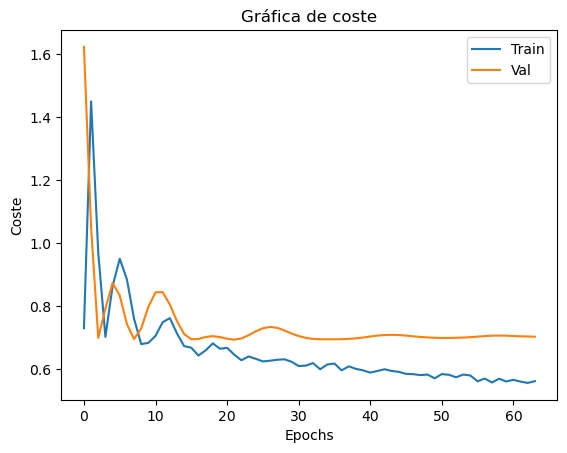

In [53]:
historial = historico.history
plt.title('Gráfica de coste')
plt.xlabel('Epochs')
plt.ylabel('Coste')
plt.plot(historial['loss'])
plt.plot(historial['val_loss'])
plt.legend(["Train", "Val"]);

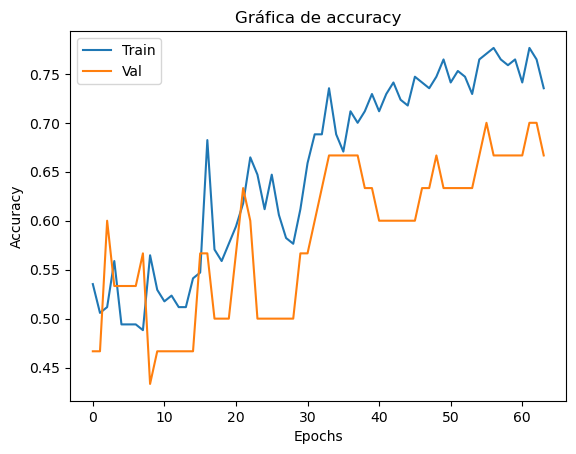

In [54]:
plt.title('Gráfica de accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(historial['acc'])
plt.plot(historial['val_acc'])
plt.legend(["Train", "Val"]);

In [55]:
prediccion = model.predict(Xtest)
aciertos = np.sum(np.round(prediccion) == ytest)
print(f'Precisión en test: {aciertos/ytest.shape[0]*100}%')

2/2 [==============================] - 0s 3ms/step
Precisión en test: 65.0%


## SVMs

In [69]:
# Importamos las SVMs
from sklearn import svm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Creamos un clasificador SVM usando svm.SVC con kernel='linear', C = 1.0
#clf = make_pipeline(StandardScaler(),  svm.SVC(kernel = 'linear', C = 1))
clf = make_pipeline(StandardScaler(),  svm.SVC(C = 3))

# Entrenamos el modelo
clf.fit(X, y.ravel())
# Obtenemos la precisión
accTrain = clf.score(X, y)
print("Precisión en train: {}%".format(accTrain*100))

print(f"Precisión en test: {clf.score(Xtest, ytest)*100}%")

Precisión en train: 100.0%
Precisión en test: 85.0%


#### Hemos obtenido un 90% de precisión en Test con ambos modelos.